In [106]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

import matplotlib.pyplot as plt


from optimizers import  DiscreteStateOptimizer, RRAMOptimizer


# Step 1: Generate Synthetic Data
n_samples = 10000
X, y = make_blobs(n_samples=n_samples, centers=2, cluster_std=1.5, random_state=42)


In [107]:

# def load_data(file_path, column, rows=None):
#     """Generic function to load data from an Excel file."""
#     df = pd.read_excel(file_path)
#     return list(df[column][:rows]) if rows else list(df[column])

# DATASETS = {
#     "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", 30),
#     "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
#     "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Conductance", 128)
# }

# # Select potentiation data
# data_choice = "vivek" 

# finite_set = load_data(*DATASETS.get(data_choice, (None, None, None)))

# print(finite_set)



def load_data(file_path, column, rows=None):
    """Generic function to load data from an Excel file."""
    df = pd.read_excel(file_path)
    return list(df[column][rows]) if rows else list(df[column])

POTENTIATION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "potentiation (mS)", range(30)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Potentiation", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Conductance", range(128))
}
DEPRESSION_DATASETS = {
    "pradeep": ("data/data_P_D_pradeep_sachan.xlsx", "depression (mS)", range(30, 60)),
    "vivek": ("data/new_data_50_pulses.xlsx", "Depression", None),
    "himanshu": ("data/himanshu_data_128_cycles.xlsx", "Conductance", range(128, 256))
}
# Select potentiation data
data_choice = "vivek" 

potentiation_conductances = load_data(*POTENTIATION_DATASETS.get(data_choice, (None, None, None)))
depression_conductances = load_data(*DEPRESSION_DATASETS.get(data_choice, (None, None, None)))




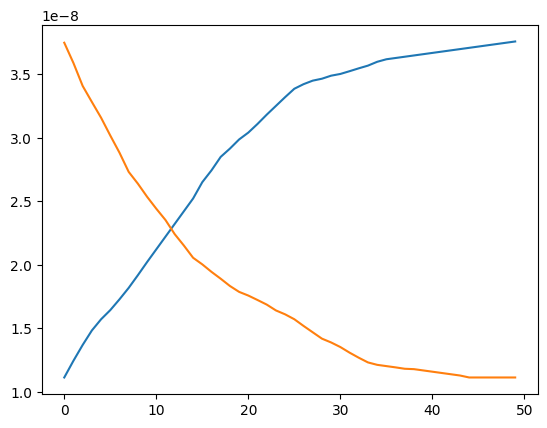

In [108]:
plt.plot(potentiation_conductances)
plt.plot(depression_conductances)

In [109]:

# Standardize the dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [110]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.fc2 = nn.Linear(16, 2)   # Hidden layer (16 neurons) to output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = self.fc2(x)               # No activation for output layer
        return x


In [111]:

# Create the model
model = MLP()
# Step 3: Train the Model
criterion = nn.CrossEntropyLoss()  # Loss function
# optimizer = FiniteSetOptimizer(model.parameters(),finite_set=finite_set, tau=0.05)
# optimizer = DiscreteStateOptimizer(model.parameters(), conductance_list=finite_set, tau=0.05)
optimizer = RRAMOptimizer(model.parameters(), potentiation_conductances, depression_conductances, 0.05)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X_train_tensor)  # Forward pass
    loss = criterion(outputs, y_train_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [2/20], Loss: 0.4120
Epoch [4/20], Loss: 0.1854
Epoch [6/20], Loss: 0.1215
Epoch [8/20], Loss: 0.0982
Epoch [10/20], Loss: 0.0982
Epoch [12/20], Loss: 0.0982
Epoch [14/20], Loss: 0.0982
Epoch [16/20], Loss: 0.0982
Epoch [18/20], Loss: 0.0982
Epoch [20/20], Loss: 0.0982


Accuracy: 99.80%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Confusion Matrix:
[[1981    8]
 [   0 2011]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1989
           1       1.00      1.00      1.00      2011

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



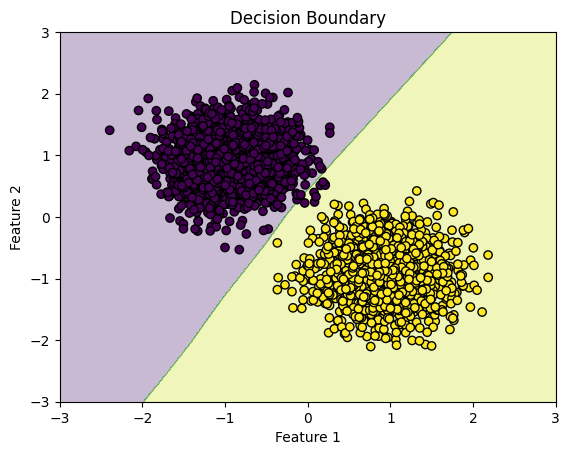

In [112]:

# Step 4: Evaluate the Model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test_tensor, predicted)
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    cm = confusion_matrix(y_test_tensor, predicted)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print('Confusion Matrix:')
    print(cm)
    print('\nClassification Report:')
    print(classification_report(y_test_tensor, predicted))

# Plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 1000), np.linspace(-3, 3, 1000))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
with torch.no_grad():
    Z = model(grid)
    _, Z = torch.max(Z.data, 1)
Z = Z.numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k')
plt.title('Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
